# <center>**`Project Details`**</center>

#### **Purpose**:

Our goal is to build a chatbot from scratch with LangGraph, FastAPI & Streamlit. The conversation flows will be managed with LangGraph and we will use FastAPI to serve the chatbot endpoint. We will finnaly build a Streamlit UI to interact with the backend API.

#### **Constraints**:

 - Use local **ollama**


#### **Tools**:

 - None

#### **Requirements**:
 - Make it work as expected


***

## <center>**`Implementation`**</center>

## **`Backend`**

### Utils functions

In [3]:
#%%writefile ../backend/utils/model_params.py
# model variables
MODEL_URL = "http://ollama:11434"
MODEL_NAME = "llama3.2"
MODEL_TEMP = 0.0
SYSTEM_PROMPT = "You are a helpful assistant."

In [4]:
#%%writefile ../backend/utils/model_provider.py

from langchain_ollama import ChatOllama
#from utils.model_params import MODEL_URL, MODEL_NAME, MODEL_TEMP

def load_model(url:str=MODEL_URL, model_name: str=MODEL_NAME, temperature:float=MODEL_TEMP, **kwargs):
    """Load local ollama model"""
    return ChatOllama(base_url=url, model=model_name, temperature=temperature, **kwargs)

### Core

#### State variable

In [5]:
#%%writefile ../backend/core/state.py
from typing import TypedDict, Dict, Any, Annotated, Sequence, Optional
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class ChatState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    session_id : Optional[str] = None

#### Nodes

In [6]:
#%%writefile ../backend/core/nodes.py

#from core.state import ChatState
#from utils.model_provider import load_model
#from utils.model_params import MODEL_URL, MODEL_NAME, MODEL_TEMP, SYSTEM_PROMPT
from langchain_core.messages import SystemMessage


class ChatNode:
    def __init__(self, url:str=MODEL_URL,
                 model_name:str=MODEL_NAME,
                 temperature:float=MODEL_TEMP,
                 system_prompt:str=SYSTEM_PROMPT):
        self.systeme_message = SystemMessage(content=system_prompt)
        self.model = load_model(url, model_name, temperature)

    def run(self, state: ChatState) -> ChatState:
        messages = state["messages"]

        if not messages or type(messages[0]) != SystemMessage:
            messages.insert(0, self.systeme_message)

        response = self.model.invoke(messages)
        state["messages"].append(response)
        return state

#### The graph

In [7]:
#%%writefile ../backend/core/graph.py

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
#from core.state import ChatState
#from core.nodes import ChatNode
from IPython.display import Image, display
from typing import Optional
from langchain_core.runnables import RunnableConfig

class ChatGraph:
    def __init__(self):
        # nodes
        self.chat_node = ChatNode()

        # memory saver
        self.memory_saver = MemorySaver()

    def graph_builder(self):
        graph_builder = StateGraph(ChatState)

        # Nodes
        graph_builder.add_node("chat_agent", self.chat_node.run)

        # Edges
        graph_builder.add_edge(START, "chat_agent")

        # return compiled graph
        return graph_builder.compile(checkpointer=self.memory_saver)
    
    @property
    def graph(self):
        if hasattr(self, "_graph"):
            return self._graph
        self._graph = self.graph_builder()
        return self._graph
    
    def display(self):
        display(Image(self.graph.get_graph(xray=True).draw_mermaid_png()))

    def invoke(self, input:str, config: Optional[RunnableConfig]=None):
        return self.graph.invoke(input, config)

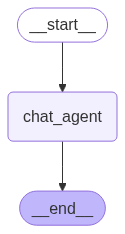

In [8]:
graph = ChatGraph()
graph.display()

### Backend

#### 

##### Data models for (backend) api

In [7]:
%%writefile ../backend/api/models.py
from pydantic import BaseModel, Field

class ChatRequest(BaseModel):
    user_input: str
    recursion_limit: int=Field(default=25)

class ChatResponse(BaseModel):
    response: str
    session_id: str

Overwriting ../backend/api/models.py


##### Backend logic

In [8]:
%%writefile ../backend/api/main.py
from fastapi import FastAPI, HTTPException
import logging
from typing import Dict, Any
from api.models import ChatRequest, ChatResponse
from core.graph import ChatGraph
import uuid
import traceback
from langchain_core.messages import HumanMessage


# configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# define the app
app = FastAPI(
    title="Smart AI Chat Agent API",
    description="API for interacting with the smart chatbot",
    version="1.0.0"
)

# store chat sessions
chat_sessions : Dict[str, Dict[str, Any]] = {}

# end points
@app.post("/chat/start", response_model=ChatResponse)
async def start_chat(request: ChatRequest):
    """Start a new chat session with the chatbot"""
    try:
        # create a new graph instance
        graph = ChatGraph()

        # generate a unique session id
        session_id = str(uuid.uuid4())

        # run a chat by invoking the graph
        inputs = {"messages":[{"role":"user",
                               "content":request.user_input}]}
        
        config = {
            "recursion_limit":request.recursion_limit,
            "configurable":{"thread_id":session_id}
            }

        output = graph.invoke(
            input=inputs,
            config=config
        )

        # store the graph instance
        chat_sessions[session_id] = {
            "graph": graph,
            "state": output,
            "config": config
        }

        return ChatResponse(
            response=output["messages"][-1].content,
            session_id=session_id
        )
    except Exception as e:
        logger.error(f"Error starting chat: {traceback.format_exc()}")
        raise HTTPException(status_code=500, detail=traceback.format_exc())
    
# continue chat
@app.post("/chat/{session_id}/continue", response_model=ChatResponse)
async def continue_chat(session_id:str, request:ChatRequest):
    if session_id not in chat_sessions:
        raise HTTPException(status_code=404, detail="Session not found")
    
    # retrieve session and add user input
    chat_session = chat_sessions[session_id]
    chat_session["state"]["messages"].append(HumanMessage(content=request.user_input))

    # submit to chat
    new_state = chat_session["graph"].invoke(chat_session["state"], chat_session["config"])

    # update session
    chat_sessions[session_id].update({"state": new_state})

    return ChatResponse(
        response=new_state["messages"][-1].content,
        session_id=session_id
    )

@app.get("/chat/sessions")
async def list_sessions():
    """List all active sessions"""
    return {"sessions": list(chat_sessions.keys())}

@app.delete("/chat/{session_id}")
async def end_session(session_id: str):
    """End a chat session"""
    if session_id not in chat_sessions:
        raise HTTPException(status_code=404, detail="Chat session not found")
    
    del chat_sessions[session_id]
    return {"message": "Session ended succesfully"}

Overwriting ../backend/api/main.py


#### Sessions persistence in the backend with SQLite database

##### Data models

In [3]:
%%writefile ../backend/api/models.py

from pydantic import BaseModel, Field
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, String, Integer, Text, DateTime, ForeignKey
from sqlalchemy.orm import relationship
import datetime

Base = declarative_base()

class ChatRequest(BaseModel):
    user_input: str
    recursion_limit: int = Field(default=25)

class ChatResponse(BaseModel):
    response: str
    session_id: str

class Session(Base):
    __tablename__ = "sessions"
    id = Column(String, primary_key=True, index=True)
    created_at = Column(DateTime, default=datetime.datetime.now)
    messages = relationship("Message", back_populates="session", cascade="all, delete-orphan")

class Message(Base):
    __tablename__ = "messages"
    id = Column(Integer, primary_key=True, index=True)
    session_id = Column(String, ForeignKey("sessions.id"))
    role = Column(String)
    content = Column(Text)
    created_at = Column(DateTime, default=datetime.datetime.now)
    session = relationship("Session", back_populates="messages")


Overwriting ../backend/api/models.py


##### Backend logic

In [1]:
%%writefile ../backend/api/main.py
from fastapi import FastAPI, HTTPException
import logging
from typing import Dict, Any
from api.models import ChatRequest, ChatResponse, Session, Message, Base
from core.graph import ChatGraph
import uuid
import traceback
from langchain_core.messages import HumanMessage
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import datetime


# configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# sqlite database
DATABASE_URL = "sqlite:///./chatbot_sessions.db"
engine = create_engine(DATABASE_URL, connect_args={"check_same_thread": False})
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
Base.metadata.create_all(bind=engine)

# define the app
app = FastAPI(
    title="Smart AI Chat Agent API",
    description="API for interacting with the smart chatbot",
    version="2.0.0"
)


# end points
@app.post("/chat/start", response_model=ChatResponse)
async def start_chat(request: ChatRequest):
    """Start a new chat session with the chatbot"""
    db = SessionLocal()
    try:
        # generate a unique session id
        session_id = str(uuid.uuid4())

        # create a new graph instance
        graph = ChatGraph()        

        # run a chat by invoking the graph
        inputs = {"messages":[{"role":"user",
                               "content":request.user_input}]}
        
        config = {
            "recursion_limit":request.recursion_limit,
            "configurable":{"thread_id":session_id}
            }

        output = graph.invoke(
            input=inputs,
            config=config
        )

        # save the session to DB
        new_session = Session(id=session_id)
        db.add(new_session)
        db.commit()

        # save messages to DB
        user_msg = Message(session_id=session_id, role="user", content=request.user_input)
        db.add(user_msg)
        ai_msg = Message(session_id=session_id, role="ai", content=output["messages"][-1].content)
        db.add(ai_msg)
        db.commit()    

        return ChatResponse(
            response=output["messages"][-1].content,
            session_id=session_id
        )
    except Exception as e:
        logger.error(f"Error starting chat: {traceback.format_exc()}")
        db.rollback()
        raise HTTPException(status_code=500, detail=traceback.format_exc())
    finally:
        db.close()
    
# continue chat
@app.post("/chat/{session_id}/continue", response_model=ChatResponse)
async def continue_chat(session_id:str, request:ChatRequest):
    db = SessionLocal()
    try:
        session_obj = db.query(Session).filter(Session.id == session_id).first()
        if not session_obj:
            raise HTTPException(status_code=404, detail="Session not found")
        

        # get messages and format them
        messages = db.query(Message).filter(Message.session_id == session_id).order_by(Message.created_at).all()
        history = []
        for msg in messages:
            if msg.role == "system":
                history.append({"role":"system", "content":msg.content})
            elif msg.role == "user":
                history.append({"role":"user", "content":msg.content})
            else:
                history.append({"role":"assistant", "content":msg.content})

        # add latest user input
        history.append({"role":"user", "content":request.user_input})

        # invoke graph
        graph = ChatGraph()
        config = {
            "recursion_limit": request.recursion_limit,
            "configurable": {"thread_id": session_id}
        }
        output = graph.invoke(
            input={"messages": history},
            config=config
        )

        # save messages to DB
        user_msg = Message(session_id=session_id, role="user", content=request.user_input)
        ai_msg = Message(session_id=session_id, role="ai", content=output["messages"][-1].content)
        db.add(user_msg)
        db.add(ai_msg)
        db.commit()

        return ChatResponse(
            response=output["messages"][-1].content,
            session_id=session_id
        )
    except Exception as e:
        logger.error(f"Error continuing chat: {traceback.format_exc()}")
        db.rollback()
        raise HTTPException(status_code=500, detail=traceback.format_exc())        
    finally:
        db.close()
    

@app.get("/chat/sessions")
async def list_sessions():
    """List all active sessions with metadata"""
    db = SessionLocal()
    try:
        sessions = db.query(Session).order_by(Session.created_at).all()
        return {
            "sessions": [
                {
                    "session_id": s.id,
                    "created_at": s.created_at.isoformat()
                }
                for s in sessions
            ]
        }
    finally:
        db.close()

@app.delete("/chat/{session_id}")
async def end_session(session_id: str):
    """End a chat session"""
    db = SessionLocal()
    try:
        session_obj = db.query(Session).filter(Session.id == session_id).first()
        if not session_obj:
            raise HTTPException(status_code=404, detail="Chat session not found")
        
        db.delete(session_obj)
        db.commit()

        return {"message": "Session ended succesfully"}
    finally:
        db.close()


@app.get("/chat/{session_id}/history")
async def get_history(session_id: str):
    """Get full message history for a session"""
    db = SessionLocal()
    try:
        messages = db.query(Message).filter(Message.session_id == session_id).order_by(Message.created_at).all()

        return [
            {"role": msg.role, "content": msg.content, "created_at": msg.created_at.isoformat()}
            for msg in messages
        ]
    finally:
        db.close()


Overwriting ../backend/api/main.py


## **`Frontend`**

In [28]:
%%writefile ../frontend/chatbot_ui.py
import streamlit as st
import requests

# FastAPI server Url
API_URL = "http://127.0.0.1:8000" # To change when deployed

st.title("Smart chatbot")

# Session state for chat history
if "session_id" not in st.session_state:
    st.session_state.session_id = None
if "messages" not in st.session_state:
    st.session_state.messages = []

# display chat history
for message in st.session_state.messages:
    role = "user" if message["role"] == "user" else "ai"
    st.chat_message(role).write(message["content"])

# user input field
user_input = st.chat_input("Ask me anything")

if user_input:
    # Add user message to chat history and display it directly
    st.session_state.messages.append({"role": "user", "content": user_input})
    st.chat_message("user").write(user_input)

    # Detect if the session is new or not
    if st.session_state.session_id is None:
        # Start a new chat session
        response = requests.post(f"{API_URL}/chat/start", json={"user_input":user_input})
        if response.status_code == 200:
            data = response.json()
            st.session_state.session_id = data.get("session_id")
            ai_response = data.get("response")
            st.session_state.messages.append({"role":"ai", "content":ai_response})
            st.chat_message("ai").write(ai_response)

        else:
            st.error("Failed to start chat session.")
    else:
        # Continue an existing chat
        response = requests.post(f"{API_URL}/chat/{st.session_state.session_id}/continue",
                                 json={"user_input":user_input})
        
        if response.status_code == 200:
            data = response.json()
            ai_response = data.get("response")
            st.session_state.messages.append({"role":"ai", "content":ai_response})
            st.chat_message("ai").write(ai_response)
        else:
            st.error("Failed to continue chat.")

Overwriting ../frontend/chatbot_ui.py


##### Add a left panel to show sessions

In [1]:
%%writefile ../frontend/chatbot_ui.py
import streamlit as st
import requests
import uuid


# FastAPI server Url
API_URL = "http://127.0.0.1:8000" # To change when deployed

st.title("Smart chatbot")

# Session state for chat history
if "sessions" not in st.session_state:
    st.session_state.sessions = {} # will be in the form of {friendly_name: [{"role": ..., "content": ...}]}
if "session_id_map" not in st.session_state:
    st.session_state.session_id_map = {}  # {friendly_name: backend_session_id}
if "current_session" not in st.session_state:
    st.session_state.current_session = None
if "pending_session" not in st.session_state:
    st.session_state.pending_session = False


# add a session at startup
if not st.session_state.sessions:
    friendly_name = "Session 1"
    st.session_state.sessions[friendly_name] = []
    st.session_state.current_session = friendly_name
    st.session_state.pending_session = True


# chat sessions sidebar
st.sidebar.header("Sessions")

#add button for new session
if st.sidebar.button("➕ New"):
    # delete pending and unused session
    if (st.session_state.current_session and
        st.session_state.pending_session and
        len(st.session_state.sessions.get(st.session_state.current_session, []))==0):
        del st.session_state.sessions[st.session_state.current_session]

        if st.session_state.current_session in st.session_state.session_id_map:
            del st.session_state.session_id_map[st.session_state.current_session]

    session_count = len(st.session_state.sessions) + 1
    friendly_name = f"Session {session_count}"
    st.session_state.sessions[friendly_name] = []
    st.session_state.current_session = friendly_name
    st.session_state.pending_session = True
    st.rerun()


# show the list of sessions
session_ids = list(st.session_state.sessions.keys())

## if user switched to another session before sending a message delete it
if (st.session_state.pending_session and
    st.session_state.current_session not in session_ids):
    for s_id in session_ids:
        if s_id.startswith("Session") and len(st.session_state.sessions[s_id]) == 0:
            del st.session_state.sessions[s_id]
            if s_id in st.session_state.session_id_map:
                del st.session_state.session_id_map[s_id]

    session_ids = list(st.session_state.sessions.keys())
    st.session_state.pending_session = False


## show sessions in vertical
for s_id in session_ids:
    s_name = f"🟢 {s_id}" if s_id == st.session_state.current_session else s_id
    if st.sidebar.button(s_name, key=f"select_{s_id}"):
        st.session_state.current_session = s_id
        st.session_state.pending_session = (
            len(st.session_state.sessions[s_id]) == 0 and s_id not in st.session_state.session_id_map
        )
        st.rerun()

if not session_ids:
    st.sidebar.write("No session")


# display chat history
chat_history = []
if st.session_state.current_session in st.session_state.sessions:
    chat_history = st.session_state.sessions[st.session_state.current_session]


for message in chat_history:
    role = "user" if message["role"] == "user" else "ai"
    st.chat_message(role).write(message["content"])

# user input field
user_input = st.chat_input("Ask me anything")

if user_input:
    session_id = st.session_state.current_session
    
    # pending ==> start a new session
    if st.session_state.pending_session:
        with st.spinner("Thinking..."):
            response = requests.post(f"{API_URL}/chat/start", json={"user_input":user_input})
        if response.status_code == 200:
            data = response.json()
            backend_session_id = data.get("session_id")
            ai_response = data.get("response")

            st.session_state.session_id_map[session_id] = backend_session_id            
            st.session_state.sessions[session_id].append({"role":"user", "content":user_input})
            st.chat_message("user").write(user_input)

            if ai_response:
                st.session_state.sessions[session_id].append({"role":"ai", "content":ai_response})
                st.chat_message("ai").write(ai_response)
        else:
            st.error("Failed to start chat session.")
        
        st.session_state.pending_session = False

    else:
        # Continue an existing chat
        backend_session_id = st.session_state.session_id_map.get(session_id)
        if backend_session_id:
            st.session_state.sessions[session_id].append({"role":"user", "content":user_input})
            st.chat_message("user").write(user_input)
            with st.spinner("Thinking..."):
                response = requests.post(f"{API_URL}/chat/{backend_session_id}/continue", 
                                            json={"user_input":user_input})
        
            if response.status_code == 200:
                data = response.json()
                ai_response = data.get("response")

                if ai_response:
                    st.session_state.sessions[session_id].append({"role":"ai", "content":ai_response})
                    st.chat_message("ai").write(ai_response)
            else:
                st.error("Failed to continue chat.")
        else:
            st.error("Session mapping lost, please start a new chat.")

Overwriting ../frontend/chatbot_ui.py


##### Save sessions persistently on disk (json file)

In [6]:
%%writefile ../frontend/chatbot_ui.py
import streamlit as st
import requests
import uuid
import os
import json

# FastAPI server Url
API_URL = "http://127.0.0.1:8000" # To change when deployed

# helper functions for saving and loading sessions
SESSIONS_FILE = "chat_sessions.json"

st.title("Smart chatbot")

def save_sessions():
    data = {
        "sessions": st.session_state.sessions,
        "last_session": st.session_state.current_session, # the last active session
        "session_id_map": st.session_state.session_id_map,
    }
    with open(SESSIONS_FILE, "w", encoding="utf-8") as f:
        json.dump(data, f)

def load_sessions():
    sessions = {}
    last_session = None
    session_id_map = {}
    if os.path.exists(SESSIONS_FILE):
        with open(SESSIONS_FILE, "r", encoding="utf-8") as f:
            data = json.load(f)
            sessions = data.get("sessions", {})
            last_session = data.get("last_session")
            session_id_map = data.get("session_id_map", {})
    return sessions, session_id_map, last_session

# load and restore saved sessions
if (
    "sessions" not in st.session_state
    or "session_id_map" not in st.session_state
    or "current_session" not in st.session_state
):
    loaded_sessions, loaded_map, last_session = load_sessions()
    st.session_state.sessions = loaded_sessions if loaded_sessions else {}
    st.session_state.session_id_map = loaded_map if loaded_map else {}

    # set current session
    if st.session_state.sessions:
        if last_session and last_session in st.session_state.sessions:
            st.session_state.current_session = last_session
        else:
            st.session_state.current_session = list(st.session_state.sessions.keys())[-1]
        st.session_state.pending_session = (
            len(st.session_state.sessions[st.session_state.current_session]) == 0
            and st.session_state.current_session not in st.session_state.session_id_map
        )
    else:
        # No sessions, create new one
        friendly_name = "Session 1"
        st.session_state.sessions[friendly_name] = []
        st.session_state.current_session = friendly_name
        st.session_state.pending_session = True
        save_sessions()

if "pending_session" not in st.session_state:
    st.session_state.pending_session = False

# add a session at startup
if not st.session_state.sessions:
    friendly_name = "Session 1"
    st.session_state.sessions[friendly_name] = []
    st.session_state.current_session = friendly_name
    st.session_state.pending_session = True


# chat sessions sidebar
st.sidebar.header("Sessions")

#add button for new session
if st.sidebar.button("➕ New"):
    # delete pending and unused session
    if (st.session_state.current_session and
        st.session_state.pending_session and
        len(st.session_state.sessions.get(st.session_state.current_session, []))==0):
        del st.session_state.sessions[st.session_state.current_session]

        if st.session_state.current_session in st.session_state.session_id_map:
            del st.session_state.session_id_map[st.session_state.current_session]
        save_sessions()

    session_count = len(st.session_state.sessions) + 1
    friendly_name = f"Session {session_count}"
    st.session_state.sessions[friendly_name] = []
    st.session_state.current_session = friendly_name
    st.session_state.pending_session = True
    save_sessions()
    st.rerun()


# show the list of sessions
session_ids = list(st.session_state.sessions.keys())

## if user switched to another session before sending a message delete it
if (st.session_state.pending_session and
    st.session_state.current_session not in session_ids):
    for s_id in session_ids:
        if s_id.startswith("Session") and len(st.session_state.sessions[s_id]) == 0:
            del st.session_state.sessions[s_id]
            if s_id in st.session_state.session_id_map:
                del st.session_state.session_id_map[s_id]
            save_sessions()

    session_ids = list(st.session_state.sessions.keys())
    st.session_state.pending_session = False


## show sessions in vertical
for s_id in session_ids:
    s_name = f"🟢 {s_id}" if s_id == st.session_state.current_session else s_id
    if st.sidebar.button(s_name, key=f"select_{s_id}"):
        st.session_state.current_session = s_id
        st.session_state.pending_session = (
            len(st.session_state.sessions[s_id]) == 0 and s_id not in st.session_state.session_id_map
        )
        save_sessions()
        st.rerun()

if not session_ids:
    st.sidebar.write("No session")

# display chat history
chat_history = []
if st.session_state.current_session in st.session_state.sessions:
    chat_history = st.session_state.sessions[st.session_state.current_session]


for message in chat_history:
    role = "user" if message["role"] == "user" else "ai"
    st.chat_message(role).write(message["content"])

# user input field
user_input = st.chat_input("Ask me anything")

if user_input:
    session_id = st.session_state.current_session
    
    # pending ==> start a new session
    if st.session_state.pending_session:
        with st.spinner("Thinking..."):
            response = requests.post(f"{API_URL}/chat/start", json={"user_input":user_input})
        if response.status_code == 200:
            data = response.json()
            backend_session_id = data.get("session_id")
            ai_response = data.get("response")

            st.session_state.session_id_map[session_id] = backend_session_id            
            st.session_state.sessions[session_id].append({"role":"user", "content":user_input})
            save_sessions()
            st.chat_message("user").write(user_input)

            if ai_response:
                st.session_state.sessions[session_id].append({"role":"ai", "content":ai_response})
                save_sessions()
                st.chat_message("ai").write(ai_response)
        else:
            st.error("Failed to start chat session.")
        
        st.session_state.pending_session = False

    else:
        # Continue an existing chat
        backend_session_id = st.session_state.session_id_map.get(session_id)
        if backend_session_id:
            st.session_state.sessions[session_id].append({"role":"user", "content":user_input})
            save_sessions()
            st.chat_message("user").write(user_input)
            with st.spinner("Thinking..."):
                response = requests.post(f"{API_URL}/chat/{backend_session_id}/continue", 
                                            json={"user_input":user_input})
        
            if response.status_code == 200:
                data = response.json()
                ai_response = data.get("response")

                if ai_response:
                    st.session_state.sessions[session_id].append({"role":"ai", "content":ai_response})
                    save_sessions()
                    st.chat_message("ai").write(ai_response)
            else:
                st.error("Failed to continue chat.")
        else:
            st.error("Session mapping lost, please start a new chat.")

Overwriting ../frontend/chatbot_ui.py


##### Save sessions mapping as persistence is now in the backend

In [1]:
%%writefile ../frontend/chatbot_ui.py
import streamlit as st
import requests

# FastAPI server Url
API_URL = "http://127.0.0.1:8000" # To change when deployed

st.title("Smart chatbot")

# util functions

def fetch_sessions():
    try:
        resp = requests.get(f"{API_URL}/chat/sessions")
        if resp.status_code == 200:
            data = resp.json()
            return data.get("sessions", [])
    except Exception:
        pass
    return []

def fetch_history(session_id):
    try:
        resp = requests.get(f"{API_URL}/chat/{session_id}/history")
        if resp.status_code == 200:
            return resp.json()
    except Exception:
        pass
    return []


# session state variable
if "session_map" not in st.session_state:
    st.session_state.session_map = {} # {session_name: backend_id}: to store friendly name with corresponding backend session id
if "active_session" not in st.session_state:
    st.session_state.active_session = None
if "pending_new_session" not in st.session_state:
    st.session_state.pending_new_session = False


# load and restore saved sessions
backend_sessions = fetch_sessions()
friendly_names = []
backend_map = {}

## build friendly names and mapping
for i, session in enumerate(backend_sessions, 1):
    friendly_id = f"Session {i}"
    friendly_names.append(friendly_id)
    backend_map[friendly_id] = session["session_id"]

## add mapping to session state and restore session
st.session_state.session_map = backend_map
if not st.session_state.active_session and not st.session_state.pending_new_session and friendly_names:
    st.session_state.active_session = friendly_names[-1]


if st.sidebar.button("➕ New"):
    st.session_state.active_session = None
    st.session_state.pending_new_session = True
    st.rerun()

# chat sessions sidebar
st.sidebar.header("Sessions")

# show the list of sessions
for active_session in friendly_names:
    label = f"🟢 {active_session}" if active_session == st.session_state.active_session else active_session
    if st.sidebar.button(label, key=f"select_{active_session}"):
        st.session_state.active_session = active_session
        st.session_state.pending_new_session = False
        st.rerun()

if not friendly_names:
    st.sidebar.write("No session")


# display chat history
if st.session_state.active_session and st.session_state.active_session in st.session_state.session_map:
    backend_id = st.session_state.session_map[st.session_state.active_session]
    chat_history = fetch_history(backend_id)
    for msg in chat_history:
        role = "user" if msg["role"] == "user" else "ai"
        st.chat_message(role).write(msg["content"])
#elif st.session_state.pending_new_session:
#    st.info("Type a message to start a new chat.")
#    chat_history = []
else:
    st.info("Type a message to start a new chat.")
    chat_history = []

# user input field
user_input = st.chat_input("Ask me anything")

if user_input:
    # if no session is selected, start a new one
    if not friendly_names:
        st.session_state.pending_new_session = True

    # start a new session
    if st.session_state.pending_new_session:
        with st.spinner("Thinking..."):
            response = requests.post(f"{API_URL}/chat/start", json={"user_input": user_input})

        if response.status_code == 200:
            data = response.json()
            session_id = data["session_id"]

            # reload session list as we just created one
            backend_sessions = fetch_sessions()
            friendly_names = []
            backend_map = {}
            for i, session in enumerate(backend_sessions, 1):
                friendly_id = f"Session {i}"
                friendly_names.append(friendly_id)
                backend_map[friendly_id] = session["session_id"]


            # find the name that matches the new session_id
            for friendly_id, backend_sid in backend_map.items():
                if backend_sid == session_id:
                    st.session_state.active_session = friendly_id
                    break
            
            st.session_state.session_map = backend_map
            st.session_state.pending_new_session = False
            st.rerun()
        else:
            st.error("Failed to start chat session.")

    elif st.session_state.active_session and st.session_state.active_session in st.session_state.session_map:
        backend_id = st.session_state.session_map[st.session_state.active_session]
        with st.spinner("Thinking..."):
            response = requests.post(
                f"{API_URL}/chat/{backend_id}/continue",
                json={"user_input": user_input}
            )
        if response.status_code == 200:
            st.rerun()
        else:
            st.error("Failed to continue chat.")

Overwriting ../frontend/chatbot_ui.py


##### Let's add a button to delete a session

In [ ]:
%%writefile ../frontend/chatbot_ui.py
import streamlit as st
import requests

# FastAPI server Url
API_URL = "http://127.0.0.1:8000" # To change when deployed

st.title("Smart chatbot")

# util functions

def fetch_sessions():
    try:
        resp = requests.get(f"{API_URL}/chat/sessions")
        if resp.status_code == 200:
            data = resp.json()
            return data.get("sessions", [])
    except Exception:
        pass
    return []

def fetch_history(session_id):
    try:
        resp = requests.get(f"{API_URL}/chat/{session_id}/history")
        if resp.status_code == 200:
            return resp.json()
    except Exception:
        pass
    return []

def delete_session(session_id):
    try:
        resp = requests.delete(f"{API_URL}/chat/{session_id}")
        return resp.status_code == 200
    except Exception:
        return False

# session state variable
if "session_map" not in st.session_state:
    st.session_state.session_map = {} # {session_name: backend_id}: to store friendly name with corresponding backend session id
if "active_session" not in st.session_state:
    st.session_state.active_session = None
if "pending_new_session" not in st.session_state:
    st.session_state.pending_new_session = False


# load and restore saved sessions
backend_sessions = fetch_sessions()
friendly_names = []
backend_map = {}

## build friendly names and mapping
for i, session in enumerate(backend_sessions, 1):
    friendly_id = f"Session {i}"
    friendly_names.append(friendly_id)
    backend_map[friendly_id] = session["session_id"]

## add mapping to session state and restore session
st.session_state.session_map = backend_map
if not st.session_state.active_session and not st.session_state.pending_new_session and friendly_names:
    st.session_state.active_session = friendly_names[-1]

# button to create new session
if st.sidebar.button("➕ New"):
    st.session_state.active_session = None
    st.session_state.pending_new_session = True
    st.rerun()

# chat sessions sidebar title
st.sidebar.header("Sessions")

delete_trigger = None

# show the list of sessions
for idx, friendly_id in enumerate(friendly_names):
    session_id = st.session_state.session_map[friendly_id]
    col1, col2 = st.sidebar.columns([8, 1])
    with col1:
        label = f"🟢 {friendly_id}" if friendly_id == st.session_state.active_session else friendly_id
        if st.button(label, key=f"select_{friendly_id}"):
            st.session_state.active_session = friendly_id
            st.session_state.pending_new_session = False
            st.rerun()
    with col2:
        if st.button("🗑️", key=f"delete_{friendly_id}"):
            delete_trigger = (friendly_id, session_id)

if not friendly_names:
    st.sidebar.write("No session")

# the deletion logic
if delete_trigger is not None:
    del_friendly_id, del_session_id = delete_trigger
    success = delete_session(del_session_id)
    if success:
        # delete from session_map
        session_map = st.session_state.session_map.copy()
        session_names = list(session_map.keys())
        del session_map[del_friendly_id]

        # update current session: move to the next in list or None if empty
        if del_friendly_id == st.session_state.active_session:
            if session_names:
                del_idx = session_names.index(del_friendly_id)
                # pick next session, or previous if at end, or None if none left
                if del_idx < len(session_names) - 1:
                    st.session_state.active_session = session_names[del_idx + 1]
                elif del_idx > 0:
                    st.session_state.active_session = session_names[del_idx - 1]
                else:
                    st.session_state.active_session = None
            else:
                st.session_state.active_session = None
        st.session_state.session_map = session_map
        st.session_state.pending_new_session = False
        st.rerun()
    else:
        st.error("Failed to delete session.")

# display chat history
if st.session_state.active_session and st.session_state.active_session in st.session_state.session_map:
    backend_id = st.session_state.session_map[st.session_state.active_session]
    chat_history = fetch_history(backend_id)
    for msg in chat_history:
        role = "user" if msg["role"] == "user" else "ai"
        st.chat_message(role).write(msg["content"])
else:
    st.info("Type a message to start a new chat.")
    chat_history = []

# user input field
user_input = st.chat_input("Ask me anything")

if user_input:
    # if no session is selected, start a new one
    if not friendly_names:
        st.session_state.pending_new_session = True

    # start a new session
    if st.session_state.pending_new_session:
        with st.spinner("Thinking..."):
            response = requests.post(f"{API_URL}/chat/start", json={"user_input": user_input})

        if response.status_code == 200:
            data = response.json()
            session_id = data["session_id"]

            # reload session list as we just created one
            backend_sessions = fetch_sessions()
            friendly_names = []
            backend_map = {}
            for i, session in enumerate(backend_sessions, 1):
                friendly_id = f"Session {i}"
                friendly_names.append(friendly_id)
                backend_map[friendly_id] = session["session_id"]


            # find the name that matches the new session_id
            for friendly_id, backend_sid in backend_map.items():
                if backend_sid == session_id:
                    st.session_state.active_session = friendly_id
                    break
            
            st.session_state.session_map = backend_map
            st.session_state.pending_new_session = False
            st.rerun()
        else:
            st.error("Failed to start chat session.")

    elif st.session_state.active_session and st.session_state.active_session in st.session_state.session_map:
        backend_id = st.session_state.session_map[st.session_state.active_session]
        with st.spinner("Thinking..."):
            response = requests.post(
                f"{API_URL}/chat/{backend_id}/continue",
                json={"user_input": user_input}
            )
        if response.status_code == 200:
            st.rerun()
        else:
            st.error("Failed to continue chat.")

Overwriting ../frontend/chatbot_ui.py


##### Let's add a button to rename a session

In [8]:
%%writefile ../frontend/chatbot_ui.py
import streamlit as st
import requests
import os
import json

# FastAPI server Url
API_URL = "http://127.0.0.1:8000" # To change when deployed
NAMES_PATH = "session_names.json"

st.title("Smart chatbot")

# util functions
def load_session_names():
    """load session names from persisted file in frontend"""
    if os.path.exists(NAMES_PATH):
        with open(NAMES_PATH, "r", encoding="utf-8") as f:
            return json.load(f)
    return {}

def save_session_names(mapping):
    """save session names to persisted file in frontend"""
    with open(NAMES_PATH, "w", encoding="utf-8") as f:
        json.dump(mapping, f)

def fetch_sessions():
    """get all persisted sessions from the backend"""
    try:
        resp = requests.get(f"{API_URL}/chat/sessions")
        if resp.status_code == 200:
            data = resp.json()
            return data.get("sessions", [])
        else:
            return None  # backend reachable but bad status
    except Exception:
        return None  # backend unreachable

def fetch_history(session_id):
    """get specified session history"""
    try:
        resp = requests.get(f"{API_URL}/chat/{session_id}/history")
        if resp.status_code == 200:
            return resp.json()
        else:
            return None  # backend reachable but bad status
    except Exception:
        return None  # backend unreachable

def delete_session(session_id):
    """delete specified session"""
    try:
        resp = requests.delete(f"{API_URL}/chat/{session_id}")
        if resp.status_code == 200:
            return True
        elif resp.status_code == 404:
            return False  # session not found
        else:
            return None  # other backend error
    except Exception:
        return None  # backend unreachable

def reinit_session_renaming_vars():
    """reinit session renaming variables"""
    st.session_state.renaming_session = None
    st.session_state.rename_value = ""


# session state variables
if "active_session" not in st.session_state:
    st.session_state.active_session = None
if "pending_new_session" not in st.session_state:
    st.session_state.pending_new_session = False
if "renaming_session" not in st.session_state:
    st.session_state.renaming_session = None
if "rename_value" not in st.session_state:
    st.session_state.rename_value = ""


# load and restore saved sessions
backend_sessions = fetch_sessions() # [{"session_id": ..., "created_at": ... }, ...]
names_map = load_session_names() # {backend_session_id: friendly_name}

# each session should have a custom name, if not it's default
used_names = set()
id_to_name = {}
name_to_id = {}

if backend_sessions is not None:
    for i, session in enumerate(backend_sessions, 1):
        sid = session["session_id"]
        # give custom name
        custom_name = names_map.get(sid)
        if custom_name and custom_name not in used_names:
            friendly_name = custom_name
        else:
            # find first available default name
            base = f"Session {i}"
            n = 1
            friendly_name = base
            while friendly_name in used_names:
                friendly_name = f"{base} ({n})"
                n += 1
        id_to_name[sid] = friendly_name
        name_to_id[friendly_name] = sid
        used_names.add(friendly_name)
    # only update names_map if backend is up and we have sessions
    if set(names_map.keys()) != set(id_to_name.keys()):
        names_map = {sid: name for sid, name in id_to_name.items()}
        save_session_names(names_map)
else:
    st.sidebar.error("❌ Backend unreachable.")

# set friendly names and active session
friendly_names = list(name_to_id.keys())
if not st.session_state.active_session and not st.session_state.pending_new_session and friendly_names:
    st.session_state.active_session = friendly_names[-1]


# button to create new session
if st.sidebar.button("➕ New"):
    st.session_state.active_session = None
    st.session_state.pending_new_session = True
    reinit_session_renaming_vars() # stop any session renaming
    st.rerun()

# chat sessions sidebar title
st.sidebar.header("Sessions")

delete_trigger = None
save_rename_trigger = None
rename_error = None

# show the list of sessions
for friendly_name in friendly_names:
    sid = name_to_id[friendly_name]
    row = st.sidebar.container()
    cols = row.columns([1, 1, 5, 1])
    # edit icon
    with cols[0]:
        if st.session_state.renaming_session == friendly_name:
            st.write("✏️")
        else:
            if st.button("✏️", key=f"rename_{friendly_name}"):
                st.session_state.renaming_session = friendly_name
                st.session_state.rename_value = friendly_name
                st.rerun()
    # session label/button or text input
    with cols[2]:
        if st.session_state.renaming_session == friendly_name:
            rename_value = st.text_input(
                "Rename session",
                value=st.session_state.rename_value or friendly_name,
                key=f"rename_input_{friendly_name}", label_visibility="collapsed")
            # save when Enter if value changed
            if rename_value.strip() != friendly_name:
                save_rename_trigger = (friendly_name, rename_value.strip())
        else:
            label = f"🟢 {friendly_name}" if friendly_name == st.session_state.active_session else friendly_name
            if st.button(label, key=f"select_{friendly_name}"):
                st.session_state.active_session = friendly_name
                st.session_state.pending_new_session = False
                reinit_session_renaming_vars() # stop any session renaming
                st.rerun()
    # delete icon
    with cols[3]:
        if st.button("🗑️", key=f"delete_{friendly_name}"):
            delete_trigger = (friendly_name, sid)

if not friendly_names:
    st.sidebar.write("No session")

# the deletion logic
if delete_trigger is not None:
    del_friendly_name, del_session_id = delete_trigger
    result = delete_session(del_session_id)
    reinit_session_renaming_vars() # stop any session renaming
    if result is True:
        # delete from disk-persisted names
        if del_session_id in names_map:
            del names_map[del_session_id]
            save_session_names(names_map)
        # select new active session
        current_names = [name for name in friendly_names if name != del_friendly_name]
        if del_friendly_name == st.session_state.active_session:
            st.session_state.active_session = current_names[-1] if current_names else None
        st.session_state.pending_new_session = False
        st.rerun()
    elif result is False:
        st.error("Session not found on backend.")
    elif result is None:
        st.error("❌ Backend unreachable. Cannot delete session.")

# renaming logic
if save_rename_trigger is not None:
    old_name, new_name = save_rename_trigger
    if not new_name:
        rename_error = "Session name cannot be empty."
    elif new_name in name_to_id and new_name != old_name:
        rename_error = "Session name already exists."
    else:
        # update name
        sid = name_to_id[old_name]
        names_map[sid] = new_name
        save_session_names(names_map)
        # update active session
        if st.session_state.active_session == old_name:
            st.session_state.active_session = new_name
        reinit_session_renaming_vars() # reinit session renaming vars
        st.rerun()
    if rename_error:
        st.session_state.reneme_value = new_name
        st.sidebar.error(rename_error)

# display chat history
if st.session_state.active_session and st.session_state.active_session in name_to_id:
    backend_id = name_to_id[st.session_state.active_session]
    chat_history = fetch_history(backend_id)
    if chat_history is None:
        st.error("❌ Backend unreachable. Cannot load chat history.")
    else:
        for msg in chat_history:
            role = "user" if msg["role"] == "user" else "ai"
            st.chat_message(role).write(msg["content"])
else:
    st.info("Type a message to start a new chat.")
    chat_history = []

# user input field
user_input = st.chat_input("Ask me anything")

if user_input:
    reinit_session_renaming_vars() # stop any session renaming

    # if no session is selected, start a new one
    if not friendly_names:
        st.session_state.pending_new_session = True

    # start a new session
    if st.session_state.pending_new_session:
        with st.spinner("Thinking..."):
            response = requests.post(f"{API_URL}/chat/start", json={"user_input": user_input})

        if response.status_code == 200:
            data = response.json()
            session_id = data["session_id"]

            # reload session list as we just created one
            backend_sessions = fetch_sessions()
            for s in backend_sessions or []:
                if s["session_id"] not in names_map:
                    # assign default name
                    base = f"Session {len(names_map) + 1}"
                    new_name = base
                    n = 1
                    while new_name in names_map.values():
                        new_name = f"{base} ({n})"
                        n += 1
                    names_map[s["session_id"]] = new_name
                    save_session_names(names_map)
                    st.session_state.active_session = new_name
                    break
            
            st.session_state.pending_new_session = False
            st.rerun()
        else:
            st.error("❌ Failed to start chat session.")

    elif st.session_state.active_session and st.session_state.active_session in name_to_id:
        backend_id = name_to_id[st.session_state.active_session]
        with st.spinner("Thinking..."):
            response = requests.post(
                f"{API_URL}/chat/{backend_id}/continue",
                json={"user_input": user_input}
            )
        if response.status_code == 200:
            st.rerun()
        else:
            st.error("❌ Failed to continue chat.")

Overwriting ../frontend/chatbot_ui.py
